In [1]:
import pickle

from math import pi
from math import cos
from math import sin

from time import time
from time import sleep

from datetime import datetime

from collections import defaultdict

from dataclasses import dataclass

from statistics import mean

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from compas.datastructures import Network
from compas.datastructures import network_transformed

from compas.geometry import Transformation
from compas.geometry import Frame
from compas.geometry import transform_vectors

from compas_cem.diagrams import TopologyDiagram

from compas_cem.elements import DeviationEdge

from compas_cem.loads import NodeLoad

from compas_cem.equilibrium import static_equilibrium

from compas_cem.optimization import Optimizer

from compas_cem.optimization import DeviationEdgeParameter
from compas_cem.optimization import Optimizer
from compas_cem.optimization import OriginNodeZParameter
from compas_cem.optimization import OriginNodeYParameter
from compas_cem.optimization import TrailEdgeForceConstraint

from compas_cem.plotters import Plotter

In [51]:
def tree(network_data, load):
    """
    Create the topology diagram of a tree canopy
    """
    # Instantiate a topology diagram
    topology = TopologyDiagram()
    
    for network_name, data in network_data.items():
        # Load a json file
        network = Network.from_json(network_name)

        # Copy over edges from network to the tree's topology diagram
        for u, v in network.edges():
            line = network.edge_coordinates(u, v)
            edge = DeviationEdge.from_line(line, force=data["force"])
            topology.add_edge(edge)

        # Add loads
        if data["load_nodes"]:
            for u in network.nodes():
                xyz = network.node_coordinates(u)
                topology.add_load(NodeLoad(xyz, load))

    # Automatically append auxiliary trails
    topology.build_trails(auxiliary_trails=True)

    return topology


def reoriented_diagram(diagram, frame_from, frame_to):
    # Re-orient node positions
    transf = Transformation.from_frame_to_frame(frame_from, frame_to)
    diagram_transformed = network_transformed(diagram, transf)

    # Squash node positions to plane
    z = frame_to.point.z
    for node in diagram_transformed.nodes():
        diagram_transformed.node_attribute(node, "z", z)

    # Re-orient and squash loads
    for node in diagram_transformed.nodes():
        # loads
        load = diagram_transformed.node_load(node)
        loadt = transform_vectors([load], transf).pop()
        diagram_transformed.node_attributes(node, ("qx", "qy", "qz"), loadt)

        # reaction force
        reaction = diagram_transformed.reaction_force(node)
        reactiont = transform_vectors([reaction], transf).pop()
        diagram_transformed.node_attributes(node, ("rx", "ry", "rz"), reactiont)
        
    return diagram_transformed


def plot_diagrams(topology, form, form_opt, frame_from, frame_to, figsize=(9.0, 9.0), nodesize=15, loadscale=4.0, reactionscale=1.0):
    plottable_diagrams = [topology, form, form_opt]
    
    for diagram in plottable_diagrams:
        plotter = Plotter(figsize=figsize)

        diagram = reoriented_diagram(diagram, frame_from, frame_to)
        plotter.add(diagram, nodesize=nodesize, loadscale=loadscale, reactionscale=reactionscale)
        plotter.zoom_extents(padding=-0.3)
        plotter.show()

        
class Logger:
    opt_attrs = ["time", "evals", "penalty", "grad_norm"]
    
    def __init__(self):
        self.data = defaultdict(list)
        self.opt_data = {attr: defaultdict(dict) for attr in self.opt_attrs} 
        
    def log_opt_algorithm(self, algorithm):
        self.data["algorithm"].append(algorithm)
        
    def log_topology(self, topology):
        self.data["num_nodes"].append(topology.number_of_nodes())
        self.data["num_edges"].append(topology.number_of_edges())
        
    def log_optimizer(self, optimizer):
        self.data["num_parameters"].append(optimizer.number_of_parameters())
        self.data["num_constraints"].append(optimizer.number_of_constraints())
    
    def log_result(self, result):
        key1 = result.gradient_mode
        key2 = result.step_size_exp
        
        for attr in self.opt_attrs:
            slot = self.opt_data[attr][key1]
            value = getattr(result, attr)
            
            if not key2 in slot:
                slot[key2] = []

            slot[key2].append(value)
    
    def flush_results(self):
        self.data["results"].append(self.opt_data)
        self.opt_data = {attr: defaultdict(dict) for attr in self.opt_attrs} 

@dataclass
class OptimizationResult:
    evals : float
    time: float
    penalty: float
    grad_norm: float
    gradient_mode: str
    step_size_exp: float

In [3]:
# topology diagram parameters
force_compression = -1.0
force_tension = 0.5
load = [0.0, 0.0, -0.5]

# json file configuration
network_data = {"tree_edges_compression.json": {"force": force_compression, "load_nodes": False},
                "tree_edges_tension.json": {"force": force_tension, "load_nodes": True}}

# optimization settings
opt_algorithms = ["LBFGS", "SLSQP", "AUGLAG"]
# gradient strategy = {grad method: step_size_exponents}
gradient_strategy = {"AD": [None], "FD": [-3, -6, -9, -12]}
iters = 500  # 200
eps = 1e-6

# optimization bounds
force_bound = 5.0
position_bound = 1.5

# number of experiments to average results on
num_experiments = 10

# visualization
plot = True

figsize = (9, 7)
frame_to = Frame(point=[0.0, 0.0, 0.0],
                 xaxis=[-1.0, 0.0, 0.0],
                 yaxis=[0.0, 1.0, 0.0])

frame_from = Frame(point=[101.253712, 48.439704, 49.86105],
                   xaxis=[0.302049, 0.953292, 0.0],
                   yaxis=[-0.421185, 0.133452, 0.897103])

In [4]:
# Instantiate a logger to store information
logger = Logger()

# Create topology diagram
topology = tree(network_data, load)

# Form-finding, only for visualization purposes
form = static_equilibrium(topology)

# Constrained form-finding
# Instantiate an optimizer
opt = Optimizer()

# Find nodes that correspond to the structure's intended supports
# These nodes are those whose Z coordinate is zero
supports = list(topology.nodes_where({"z": (-0.01, 0.01)}))

# Add constraint: force in axiliary trail edges should be zero
for edge in topology.auxiliary_trail_edges():
    u, v = edge
    # Skip the edges that connect to an intended support
    if u in supports or v in supports:
        continue 
    opt.add_constraint(TrailEdgeForceConstraint(edge, force=0.0))

# Add optimization parameters
# The forces in all the deviation edges are degrees of freedom
# in the optimization problem
for edge in topology.deviation_edges():
    parameter = DeviationEdgeParameter(edge,
                                       bound_up=force_bound,
                                       bound_low=force_bound)
    opt.add_parameter(parameter)

# The Y and Z coordinates of the tree nodes are degrees of freedom
# as well
for node in topology.origin_nodes():
    # Skip the edges that connect to an intended support
    if node in supports:
        continue

    parameter = OriginNodeZParameter(node,
                                     bound_up=position_bound,
                                     bound_low=position_bound)
    opt.add_parameter(parameter)

    parameter = OriginNodeYParameter(node,
                                     bound_up=position_bound,
                                     bound_low=position_bound)
    opt.add_parameter(parameter)

# Log data
logger.log_topology(topology)
logger.log_optimizer(opt)
    
# Solve constrained form-finding problem
for opt_algorithm in opt_algorithms:
    print(f"***Solving tree with the {opt_algorithm} optimization algorithm ***\n")
    logger.log_opt_algorithm(opt_algorithm)
    
    for gradient_mode, step_size_exps in gradient_strategy.items():
        
        for step_size_exp in step_size_exps:
            
            step_size = None
            if step_size_exp is not None:
                step_size = 1 * (10 ** step_size_exp)
                
            print(f"Gradient mode: {gradient_mode}\tStep size:{step_size}")
            print(f"Running {num_experiments} experiments...")
            
            for i in tqdm(range(num_experiments)):
                # only print out optimization info of first experiment
                verbose = (i == 0)
                    
                form_opt = opt.solve(topology.copy(),
                                     algorithm=opt_algorithm,
                                     grad=gradient_mode,
                                     iters=iters,
                                     eps=eps,
                                     step_size=step_size,
                                     verbose=verbose)
                
                result = OptimizationResult(evals=opt.evals,
                                            time=opt.time_opt,
                                            penalty=opt.penalty,
                                            grad_norm=opt.gradient_norm,
                                            gradient_mode=gradient_mode,
                                            step_size_exp=step_size_exp)
                
                logger.log_result(result)            
            print() 
            
    logger.flush_results()
    
print("Done!")

  0%|          | 0/10 [00:00<?, ?it/s]

***Solving tree with the LBFGS optimization algorithm ***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 186, # Constraints 44
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:11<01:44, 11.59s/it]

Optimization ended correctly!
Optimization total runtime: 11.4587 seconds
Number of evaluations incurred: 78
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0013
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 186, # Constraints 44


 10%|█         | 1/10 [09:47<1:28:08, 587.59s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 587.5548 seconds


 20%|██        | 2/10 [19:31<1:18:02, 585.27s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 583.6264 seconds


 30%|███       | 3/10 [29:15<1:08:13, 584.76s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 584.1152 seconds


 40%|████      | 4/10 [39:00<58:28, 584.73s/it]  

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 584.6598 seconds


 50%|█████     | 5/10 [48:45<48:45, 585.10s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 585.739 seconds


 60%|██████    | 6/10 [58:31<39:01, 585.38s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 585.8916 seconds


 70%|███████   | 7/10 [1:08:18<29:17, 585.89s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 586.9131 seconds


 80%|████████  | 8/10 [1:18:04<19:31, 585.85s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 585.7401 seconds


 90%|█████████ | 9/10 [1:27:50<09:46, 586.03s/it]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 586.4102 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

Optimization failed for reasons I do not grasp yet...
Optimization total runtime: 586.5883 seconds

Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:27<40:08, 267.63s/it]

Optimization total runtime: 265.3461 seconds
Number of evaluations incurred: 120
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0013
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:25<39:51, 265.77s/it]

Optimization total runtime: 263.5245 seconds
Number of evaluations incurred: 120
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0008
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with LBFGS started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [05:00<45:07, 300.81s/it]

Optimization total runtime: 298.5595 seconds
Number of evaluations incurred: 135
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0009
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving tree with the SLSQP optimization algorithm ***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 186, # Constraints 44
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:18<02:50, 19.00s/it]

Optimization ended correctly!
Optimization total runtime: 18.8096 seconds
Number of evaluations incurred: 154
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0014
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [06:15<56:17, 375.22s/it]

Optimization total runtime: 372.9579 seconds
Number of evaluations incurred: 500
Final value of the objective function: 0.0012
Norm of the gradient of the objective function: 0.0221
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:34<41:11, 274.66s/it]

Optimization total runtime: 272.4261 seconds
Number of evaluations incurred: 178
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0014
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:37<41:37, 277.49s/it]

Optimization total runtime: 275.2594 seconds
Number of evaluations incurred: 182
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0015
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with SLSQP started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:58<44:46, 298.55s/it]

Optimization total runtime: 296.2773 seconds
Number of evaluations incurred: 194
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0016
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


***Solving tree with the AUGLAG optimization algorithm ***

Gradient mode: AD	Step size:None
Running 10 experiments...
----------
Optimization with AUGLAG started!
# Parameters: 186, # Constraints 44
Computing gradients using automatic differentiation!


 10%|█         | 1/10 [00:25<03:53, 25.96s/it]

Optimization ended correctly!
Optimization total runtime: 25.7692 seconds
Number of evaluations incurred: 155
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0014
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:0.001
Running 10 experiments...
----------
Optimization with AUGLAG started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [06:37<59:40, 397.78s/it]

Optimization total runtime: 394.9677 seconds
Number of evaluations incurred: 501
Final value of the objective function: 0.0012
Norm of the gradient of the objective function: 0.0221
Optimization status: NLOPT_ITERSMAX_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-06
Running 10 experiments...
----------
Optimization with AUGLAG started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:46<42:57, 286.40s/it]

Optimization total runtime: 284.0589 seconds
Number of evaluations incurred: 179
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0014
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-09
Running 10 experiments...
----------
Optimization with AUGLAG started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [05:18<47:46, 318.51s/it]

Optimization total runtime: 315.9959 seconds
Number of evaluations incurred: 183
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0015
Optimization status: NLOPT_EPSVAL_REACHED
----------


  0%|          | 0/10 [00:00<?, ?it/s]


Gradient mode: FD	Step size:1e-12
Running 10 experiments...
----------
Optimization with AUGLAG started!
# Parameters: 186, # Constraints 44
Optimization ended correctly!


 10%|█         | 1/10 [04:40<42:01, 280.13s/it]

Optimization total runtime: 278.0109 seconds
Number of evaluations incurred: 195
Final value of the objective function: 0.0
Norm of the gradient of the objective function: 0.0016
Optimization status: NLOPT_EPSVAL_REACHED
----------


100%|██████████| 10/10 [46:27<00:00, 278.80s/it]


Done!


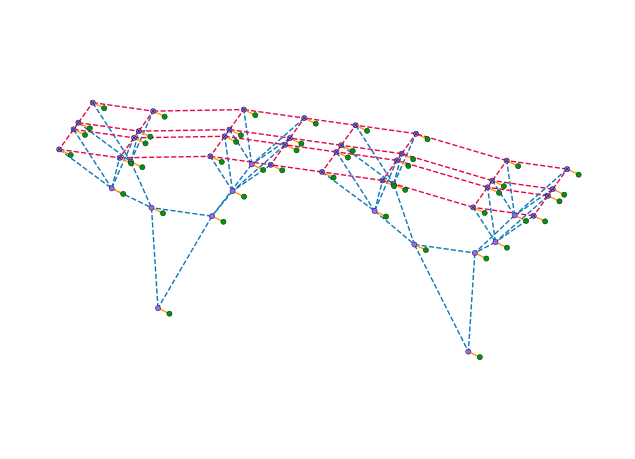

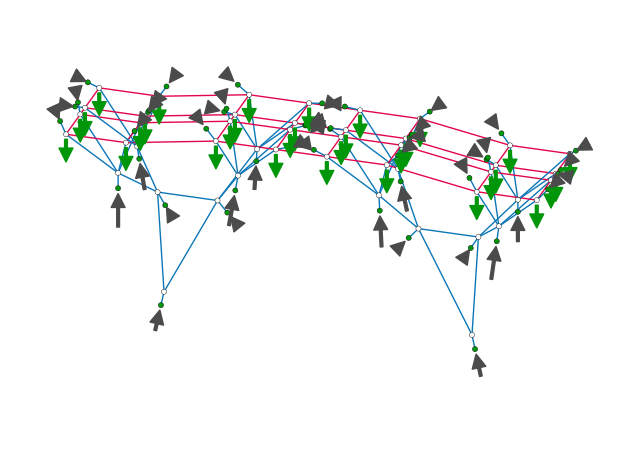

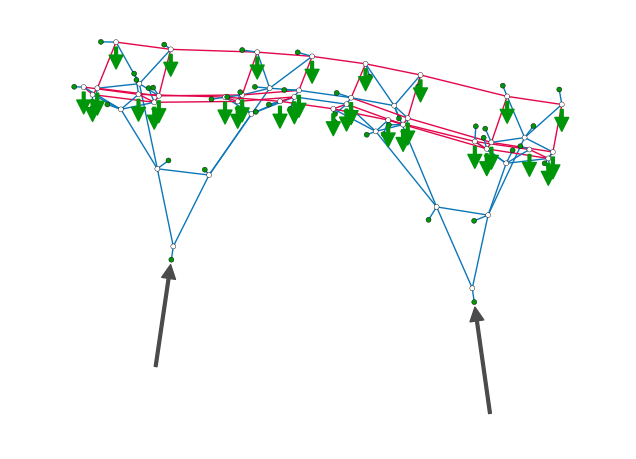

In [53]:
# Plot topology, form and constrained form diagrams
if plot:
    plot_diagrams(topology, form, form_opt, frame_from, frame_to, figsize=figsize)

In [7]:
for key, value in logger.data.items():
    if key != "results":
        print(f"{key}: {value}")
        continue
    for v in value:
        print(v)

num_nodes: [92]
num_edges: [144]
num_parameters: [186]
num_constraints: [44]
algorithm: ['LBFGS', 'SLSQP', 'AUGLAG']
{'time': defaultdict(<class 'dict'>, {'AD': {None: [11.458737850189209, 9.919343948364258, 10.013706922531128, 11.647128820419312, 11.632182121276855, 11.159250020980835, 11.417330026626587, 11.459696054458618, 11.493973016738892, 11.319700956344604]}, 'FD': {-3: [11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604, 11.319700956344604], -6: [265.34611916542053, 265.4782888889313, 265.98326897621155, 264.64345502853394, 266.1654329299927, 266.61807894706726, 267.375746011734, 265.2871160507202, 266.486524105072, 265.72628569602966], -9: [263.52453112602234, 265.3358657360077, 265.18961095809937, 266.25976276397705, 263.6356089115143, 265.23966574668884, 266.4235529899597, 266.6775641441345, 265.05523204803467, 264.7497498989105], -12: [298.5594801

In [8]:
# export data
with open("tree.pkl", "wb") as file:
    pickle.dump(logger.data, file, pickle.HIGHEST_PROTOCOL)

In [9]:
def pretty_matplotlib():
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=20)
    plt.rc('axes', linewidth=1.5, labelsize=20)
    plt.rc('xtick', labelsize=20, direction="in")
    plt.rc('ytick', labelsize=20, direction="in")
    plt.rc('legend', fontsize=15)

    # tick settings
    plt.rc('xtick.major', size=10, pad=4)
    plt.rc('xtick.minor', size=5, pad=4)
    plt.rc('ytick.major', size=10)
    plt.rc('ytick.minor', size=5)
    
    # hatches
    # plt.rcParams['hatch.linewidth'] = 0.5
    plt.rc('hatch', linewidth=0.5)

    
def create_figure(figsize, dpi):
#     fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    return fig


def plot_bar(x, y, label, width=0.90, alpha=1.0, hatch=None, color=None):
    bar = plt.bar(x, y, width, label=label, color=color, alpha=alpha)
    for b in bar:
        b.set_hatch(hatch)

    
def save_figure(filename, extension="pdf", box_inches="tight", pad_inches=0.05, sleeptime=1.0):
    path = f"{filename}.{extension}"
    plt.savefig(path, bbox_inches='tight', pad_inches=pad_inches)
    print(f"Saved image to {path}")
    sleep(sleeptime)
    
    
def show_figure():
    plt.show()

    
def decorate_figure(xlabel, ylabel, xticks, xtickslabels, yticks, ytickslabels, xscale="linear", yscale="linear", legend=True, grid_kwargs={}, tight=True):
    plt.xscale(xscale)
    plt.yscale(yscale)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.xticks(xticks, labels=xtickslabels)
    plt.yticks(yticks, labels=ytickslabels)
    
    plt.minorticks_off()
    
    plt.grid(**grid_kwargs)
    
    if legend:
        plt.legend(fontsize="small")
        
    if tight:
        plt.tight_layout()


In [62]:
data = logger.data

filename = "tree_opt"

show = True
save = True

figsize = (7, 5)
dpi = 300

width = 0.95  # the total width of all the sub bars
num_bars = 4 # number of sub bars

aggregator_func = mean

# x = data["num_parameters"]
# xscale = "linear"
opt_algorithms_viz = ["LBFGS", "SLSQP", "AUGLAG"]
step_size_exp_skippable = [-3]
xlabel = "Optimization algorithm"
ylabel = "Time per iteration (seconds)"

x = np.arange(len(opt_algorithms_viz))  # the label locations
yticks = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5]

# hatches = {"AD": {None: None}, "FD": {-3: "\\", -6: "-", -9: "/"}}
colors = {"AD": {None: "tab:blue"}, "FD": {-3: "tab:orange", -6: "tab:green", -9: "tab:red", -12: "tab:purple"}}
hatches = {"AD": {None: None}, "FD": {-3: "+", -6: "\\", -9: "-", -12: "/"}}

grid = {"ls": "--", "lw": 0.5, "which": "major", "axis": "y"}

Saved image to tree_opt_timeperiter.pdf


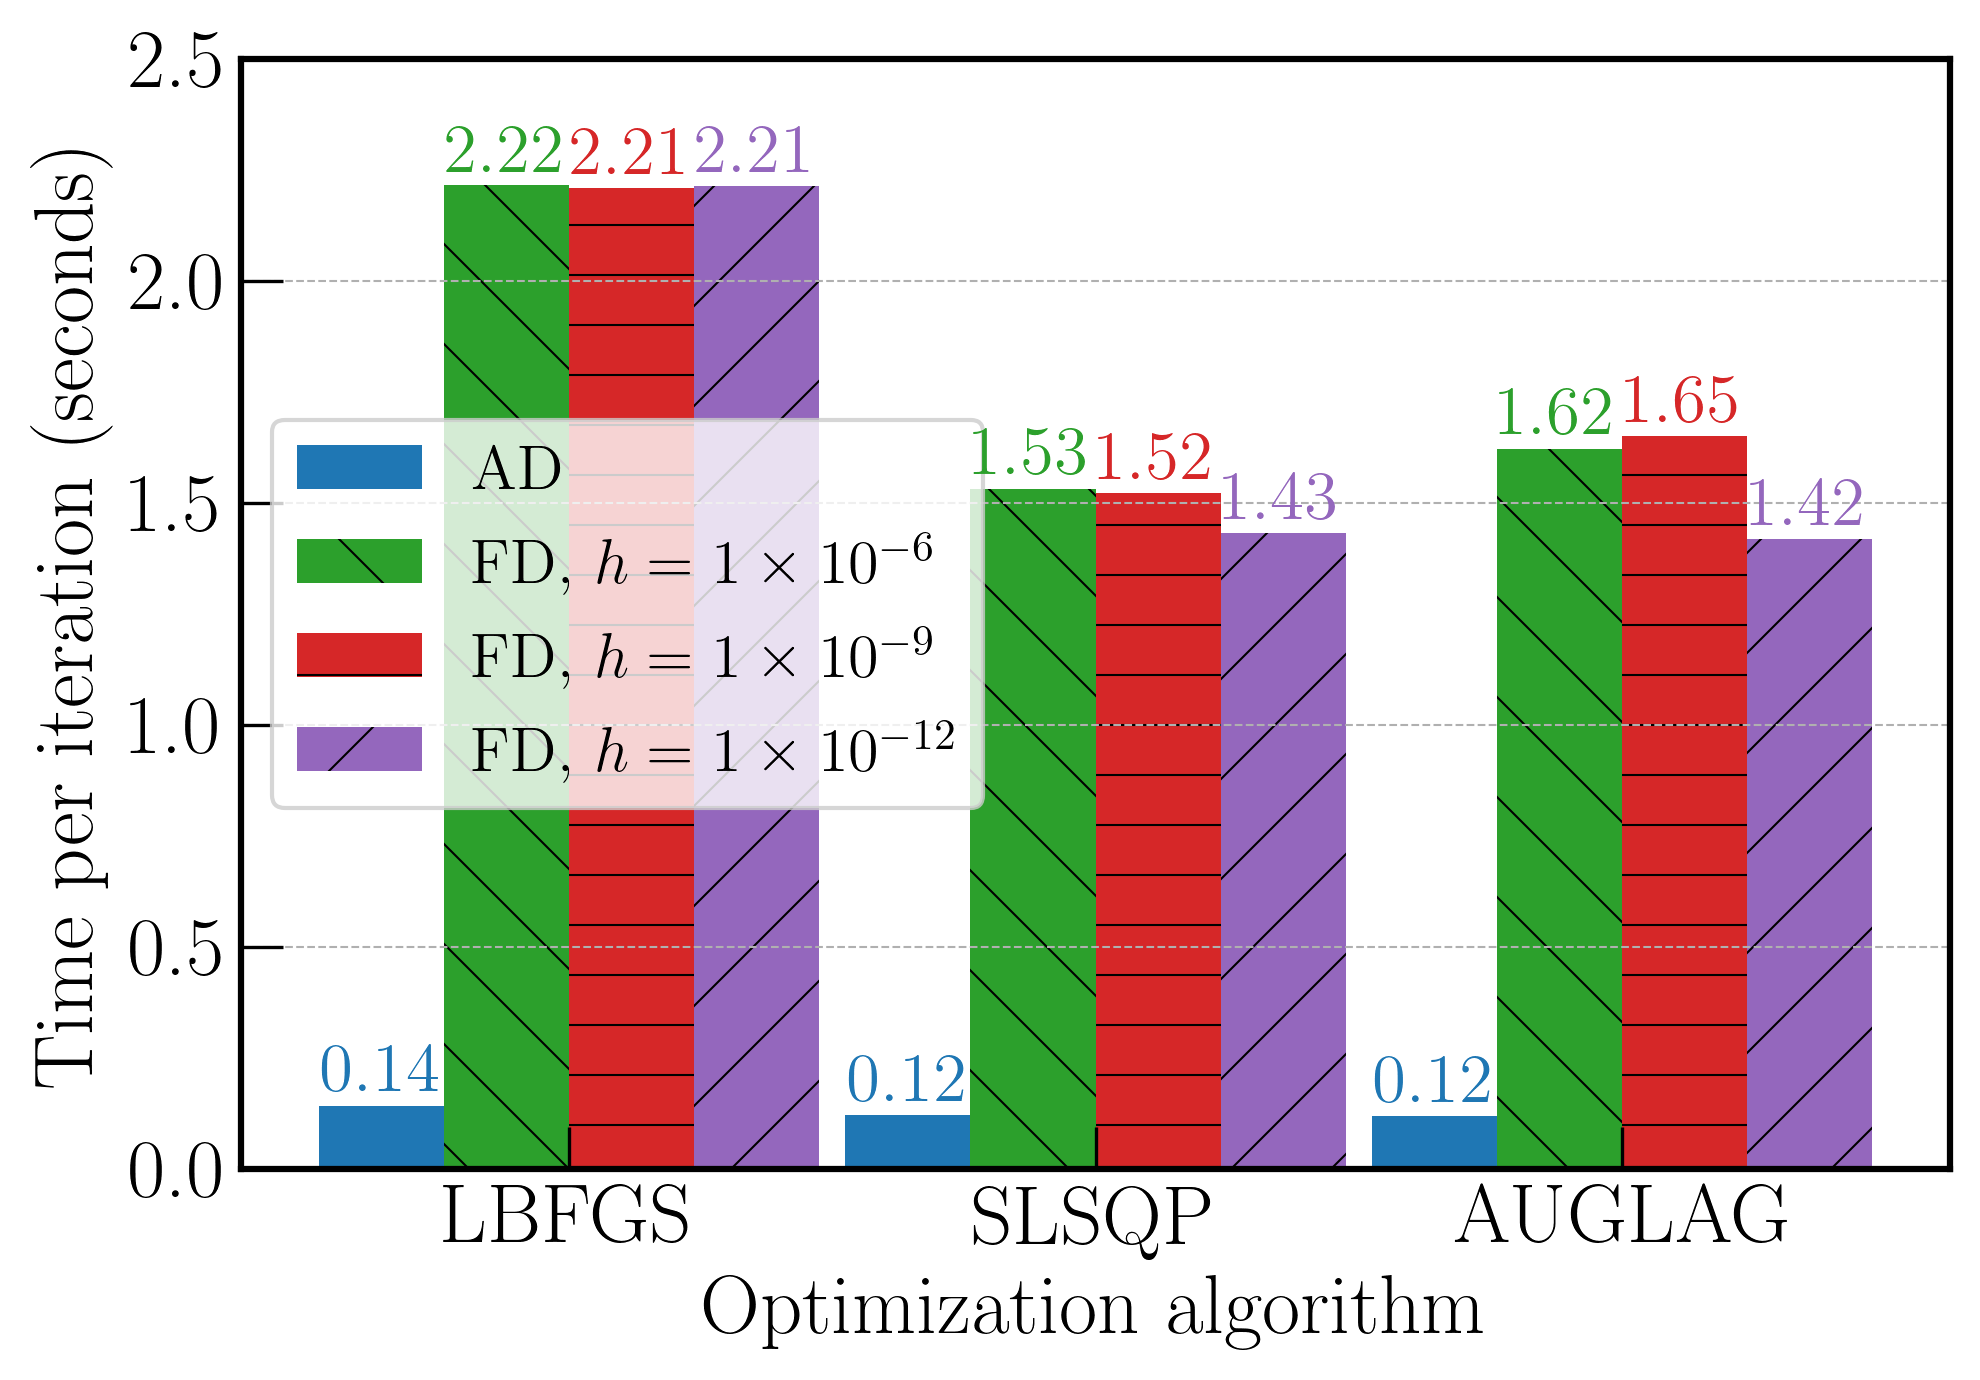

In [66]:
bar_width = width / num_bars

pretty_matplotlib()
create_figure(figsize, dpi)

count = 0
algorithms_index = {algorithm: idx for idx, algorithm in enumerate(opt_algorithms)}
for gradient_mode, step_size_exps in gradient_strategy.items():

    for step_size_exp in step_size_exps:
        
        if step_size_exp in step_size_exp_skippable:
            continue
        
        label = fr"{gradient_mode}, $h=1\times10^{ {step_size_exp} }$"
        if step_size_exp is None:
            label = r"{}".format(gradient_mode)
                    
        for idx, algorithm in enumerate(opt_algorithms_viz):

            result = data["results"][algorithms_index[algorithm]]
            opt_time = aggregator_func(result["time"][gradient_mode][step_size_exp])
            opt_iters = aggregator_func(result["evals"][gradient_mode][step_size_exp])
            time_periter = opt_time / opt_iters

            color = colors[gradient_mode][step_size_exp]
            hatch = hatches[gradient_mode][step_size_exp]
            
            _x = x[idx] + count * bar_width
            _y = time_periter
            
            plot_bar(_x, _y, width=bar_width, label=label, color=color, hatch=hatch)
            
            plt.text(_x,
                     _y,
                     f"{round(_y, 2)}",
                     size="small",
                     c=color,
                     ha="center",
                     va="bottom",
                     zorder=20000)
            
        count += 1

decorate_figure(xlabel=xlabel,
                ylabel=ylabel,
                xticks=x + 1.5 * bar_width,
                xtickslabels=opt_algorithms_viz,
                yticks=yticks,
                ytickslabels=yticks,
                grid_kwargs=grid)

# remove duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="center left")

if save:
    save_figure(f"{filename}_timeperiter")

if show:
    show_figure()